# Fraud Test data

Data from https://www.kaggle.com/datasets/kartik2112/fraud-detection

------------------ google colab ---------------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd 'drive/MyDrive/deep-learning/Project'

-------------------------------------------

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score 

## 1. Load data

In [ ]:
'''
data = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
data.shape # (590540, 394)
data.to_pickle('ieee_pickled.pkl')
'''

In [ ]:
df = pd.read_pickle('ieee_pickled.pkl')
print('data shape', df.shape) # size (590540, 394), second one is label
n_positive = sum(df.iloc[:, 1])
print('number of fraudulent transactions', n_positive)
print('percent fraudulent = ', n_positive/len(df)*100)

In [ ]:
# From Adrian
print(f'Memory footprint is {df.memory_usage(deep=True).sum()/2**20:.2f} MB')

print('Typecasting to appropriate data types')
for col in df:
    if df[col].dtype!=object and col!='TransactionAmt':
        df[col]=df[col].fillna(-12)
        if df[col].max()<128: df[col] = df[col].astype('int8')
        elif df[col].max()<32768: df[col] = df[col].astype('int16')
        else: df[col] = df[col].astype('int32')
    if col=='TransactionAmt':
        df[col] = df[col].astype('float32')

print(f'Memory footprint is {df.memory_usage(deep=True).sum()/2**20:.2f} MB')

print('Remaining non-int columns are the following:')
for col in df.columns:
    if df[col].dtype!='int8' and df[col].dtype!='int16' and df[col].dtype!='int32':
        print(col,df[col].dtype)

=================== scratch work ==================<br>
TransactionID is just an index, exclude from analysis.<br>
TransactionDT some kind of time, can process to get month/day. <br>
Day and start_day extracted can be used for userid. <br>

The C columns have no missing values.

In [ ]:
Dcolumns = [c for c in data.columns if c[0] == 'D']
Ccolumns = [c for c in data.columns if c[0] == 'C']
Mcolumns = [c for c in data.columns if c[0] == 'M']
Vcolumns = [c for c in data.columns if c[0] == 'V']
Cardcolumns = [c for c in data.columns if c.startswith('card')]

In [ ]:
data['day']=data['TransactionDT']//(60*60*24)
data['start_date'] = data['day']-data['D1']+10000

==================================================================

### 1.1 (optional) About missing values

If Adrian's memory reduction is ran, there would be no missing values in numerical columns

In [ ]:
nan_count = df.isna().sum()
plt.plot(nan_count)
plt.yscale('log')
plt.ylabel('number of missing values'), plt.xlabel('features')
plt.show()

In [ ]:
col_highmissingvalues = df.columns[nan_count> 0.8*len(df)]

'''
# with >85% missing values, which is the same if cutoff is 80%: 
col_highmissingvalues = ['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139',
       'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148',
       'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157',
       'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166',
       'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330',
       'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339']
'''

there are 19 features with no missing values, 52 features with fewer than 100 missing values, 94 features with fewer than 1000 missing values.<br>
In the case of < 100 missing values, all columns with missing values share the same 12 indices. 2 of these are fraud.<br>
In the case of < 1000 missing values, the missing values lie in 326 different rows. Among these, 19 of them are fraud. This ratio is a bit high.

In [ ]:
''' # some stuff about shared nan rows between columns
total_missing = []
for col in good_col:
    missing_idx = data.index[data[col].isna()].tolist()
    total_missing.extend(missing_idx)

print('number of rows with missing values', len(set(total_missing)))
print('fraudulent', sum(data.isFraud[list(set(total_missing))]))

data_nomissing = data.drop(set(total_missing))
data_label = data_nomissing['isFraud']
data_features = data_nomissing.drop(columns=['isFraud'])
'''

In [ ]:
df.R_emaildomain.nunique()

## 2. Preprocessing: split by feature type
Split into numerical and categorial columns.
For categorical, use one hot or 1/0.
For numerical, normalize.

### 2.1 Features

https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203<br>
Transaction table<br>
“It contains money transfer and also other gifting goods and service, like you booked a ticket for others, etc.”

TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
“TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”

TransactionAMT: transaction payment amount in USD
“Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75.887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?”

ProductCD: product code, the product for each transaction
“Product isn't necessary to be a real 'product' (like one item to be added to the shopping cart). It could be any kind of service.”

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

addr: address<br>
“both addresses are for purchaser
addr1 as billing region
addr2 as billing country”

dist: distance<br>
"distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”

P_ and (R__) emaildomain: purchaser and recipient email domain
“ certain transactions don't need recipient, so R_emaildomain is null.”

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
“Can you please give more examples of counts in the variables C1-15? Would these be like counts of phone numbers, email addresses, names associated with the user? I can't think of 15.
Your guess is good, plus like device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number.”

D1-D15: timedelta, such as days between previous transaction, etc.

M1-M9: match, such as names on card and address, etc.

Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
“For example, how many times the payment card associated with a IP and email or address appeared in 24 hours time range, etc.”
"All Vesta features were derived as numerical. some of them are count of orders within a clustering, a time-period or condition, so the value is finite and has ordering (or ranking). I wouldn't recommend to treat any of them as categorical. If any of them resulted in binary by chance, it maybe worth trying."

Identity Table<br>
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

DeviceInfo : https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#583227

“id01 to id11 are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc. All of these are not able to elaborate due to security partner T&C. I hope you could get basic meaning of these features, and by mentioning them as numerical/categorical, you won't deal with them inappropriately.”

====================== scratch ======================

In [ ]:
# compare nested relationship between columns
col1 = 'dist1'
col2 = 'dist2'

print('col1 and col2 have the same missing values ', (data[col1].isna() == data[col2].isna()).all()) # addr1 and addr2 have the same missing values
print('number of missing values in col1', data[col1].isna().sum(), 'number of missing values in col2', data[col2].isna().sum())
data_cols = data[[col1, col2]]
nested = data_cols.groupby(col1)[col2].nunique()
print((nested ==1).all())
plt.figure(figsize=(3, 2))
plt.hist(nested)
plt.show()
print('number of col1 values that doesn\'t match to exactly one col2 values: ', nested[nested!=1].count()) # some 35 of addr1 are associated with multiple addr2 values. if these are region vs country, maybe error??
# addr1 contains more information than addr2

==================================================================

In [ ]:
data_label = df.isFraud
data_features = df.drop(columns=['isFraud'])

# since TransactionDT is an important feature that separates train and test data, it shouldn't be part of training.
# TransactionID is just index
columns_remove = ['TransactionID', 'TransactionDT', 'addr2', 'P_emaildomain', 'R_emaildomain'] + [c for c in col_highmissingvalues]
data_features = data_features.drop(columns=columns_remove)

In [ ]:
data_features.head(10)

In [ ]:
# Numerical columns
num_cols = data_features.select_dtypes(include=['int32', 'float32', 'int64', 'float64']).columns.tolist()
print("Numerical columns:", num_cols)

# Categorical columns
cat_cols = data_features.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", cat_cols)

### 2.1 Preprocessing: categorical features
Among categorical columns, ProductCD has 5 values, card4 has 4, card6 has 4, ------> one hot <br>
P_emaildomain, R_emaildomain have a lot (59 and 60)<br>
M1-M9 except M4 are True False --------> convert to 1/0 <br>
M4 has values M0, M2, M1 ----------> numerical 0, 2, 1

In [ ]:
features_expanded = data_features.copy()

In [ ]:
for col in cat_cols:
    if col[0] == 'M':
        if col[1] != 4:
            features_expanded[col] = features_expanded[col].map({'T': 1, 'F': 0})
        else:
            features_expanded[col] = features_expanded[col].map({'M0': 0, 'M1': 1, 'M2':2})
    else:
        features_expanded = pd.get_dummies(features_expanded, columns=[col], dtype=int)

features_expanded.head()

### 2.2 Preprocessing: scaling numerical features

In [ ]:
scaler = MinMaxScaler()
features_normalized=features_expanded
features_normalized[num_cols] = scaler.fit_transform(features_normalized[num_cols])

In [ ]:
type(features_normalized)

the features can be saved as np array in npy or as a tensor in a pt. The two formats have different variable size but the corresponding saved files have similar size.

In [ ]:
torch.save(data_label, 'labels.pt')

In [ ]:
np.save('features_normalized_noemail.npy', features_normalized.values)

## 3. Autoencoder

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
labels = torch.load('labels.pt')
features_normalized = np.load('features_normalized_noemail.npy')
features_normalized = torch.from_numpy(features_normalized)

In [5]:
features_no_fraud = features_normalized[labels == 0, :]
features_fraud = features_normalized[labels == 1, :]

In [6]:
%whos

Variable              Type        Data/Info
-------------------------------------------
DataLoader            type        <class 'torch.utils.data.dataloader.DataLoader'>
MinMaxScaler          type        <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
StandardScaler        type        <class 'sklearn.preproces<...>ng._data.StandardScaler'>
TensorDataset         type        <class 'torch.utils.data.dataset.TensorDataset'>
accuracy_score        function    <function accuracy_score at 0x00000231F72C4CA0>
confusion_matrix      function    <function confusion_matrix at 0x00000231F72C4DC0>
device                device      cpu
f1_score              function    <function f1_score at 0x00000231F72CB4C0>
features_fraud        Tensor      tensor([[0.0139, 0.9926, <...>     dtype=torch.float64)
features_no_fraud     Tensor      tensor([[2.1370e-03, 7.43<...>0]], dtype=torch.float64)
features_normalized   Tensor      tensor([[2.1370e-03, 7.43<...>0]], dtype=torch.float64)
labels          

### 3.1 Train Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features_no_fraud, torch.zeros((len(features_no_fraud), 1)), test_size=0.2, random_state=42) # all training samples are nonfraud so no stratify
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_test = torch.cat((X_train, features_fraud), dim=0)
y_test = torch.cat((torch.zeros((len(y_train), 1)), torch.ones((len(features_fraud), 1))), dim=0)

In [22]:
X_val.shape[1]

343

In [8]:
del features_fraud, features_no_fraud, features_normalized, labels

In [9]:
# if nan is already filled, mask will just be all 1's. No need to remove
mask_val = ~torch.isnan(X_val) # validation set doesn't change so may as well do mask once and for all
mask_val = mask_val.to(device) # Move mask to the correct device as well
mask_train = ~torch.isnan(X_train)  # True where data is present

for col = range(X_val.shape[1])
X_val_filled = torch.nan_to_num(X_val, nan=0.0)
#X_val_filled = X_val_filled.float().to(device) # val data doesn't go through dataloader so it needs to go on gpu separately

X_filled = torch.nan_to_num(X_train, nan=0.0)  # Replace NaNs with 0
#X_filled = X_filled.float() # convert to all double (twice precision as float)



### 3.2 Autoencoder and training

In [10]:
# Define the autoencoder
class Autoencoder(nn.Module): # here the input nn.Module specifies the super class that Autoencoder is in
    # we are making an object class by modifying an existing class nn.Module
    def __init__(self, input_dim, latent_dim=64):
        super().__init__() # calls initialization of nn.Module object
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(), # this is also a layer but has no weights
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )

    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)

In [11]:
# Initialize model, optimizer, and loss
model = Autoencoder(input_dim=X_filled.shape[1]) # input size has to be number of features
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss(reduction='none')  # So we can apply a mask


In [12]:


# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_filled, mask_train)
batch_size = 512 # You can adjust this batch size based on your GPU memory
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# early-stopping things
min_improvement = 1e-5
patience = 5 # 5 do 5 more if not improved
epochs_without_improvement = 0
lowest_epoch_val_loss = float('inf') # track min loss to get best epoch

# Training loop
epochs = 60
epoch_loss = []
epoch_loss_val = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_mask in dataloader:
        batch_X, batch_mask = batch_X.to(device), batch_mask.to(device)

        optimizer.zero_grad()

        output = model(batch_X)
        loss_matrix = criterion(output, batch_X)  # [batch, features]
        masked_loss = loss_matrix * batch_mask.float()
        loss = masked_loss.sum() / batch_mask.sum()  # average over observed values only

        loss.backward()
        optimizer.step()
        total_loss += loss.item() # get value

    output = model(X_val_filled)
    loss_matrix = criterion(output, X_val_filled)  # [batch, features]
    masked_loss = loss_matrix * mask_val
    loss_val = masked_loss.sum()/mask_val.sum()
    epoch_loss_val.append(loss_val.item())
    epoch_loss.append(total_loss/len(dataloader))
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}, Validation Loss: {loss_val.item():.4f}")
    torch.save(model.state_dict(), f'autoencoder_epoch_{epoch+1}.pth')
    #print(f"Saved model state for epoch {epoch+1}")

    if lowest_epoch_val_loss - loss_val.item() > min_improvement: # improvement in val loss
        lowest_epoch_val_loss = loss_val.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    if epochs_without_improvement >= patience:
        best_epoch = np.argmin(np.array(epoch_loss_val))
        print(f"Early stopping at epoch {epoch+1}, best epoch {best_epoch + 1}")
        break


Epoch 1, Loss: 0.0040, Validation Loss: 0.0007
Epoch 2, Loss: 0.0005, Validation Loss: 0.0004
Epoch 3, Loss: 0.0004, Validation Loss: 0.0003
Epoch 4, Loss: 0.0003, Validation Loss: 0.0003
Epoch 5, Loss: 0.0002, Validation Loss: 0.0002
Epoch 6, Loss: 0.0002, Validation Loss: 0.0002
Epoch 7, Loss: 0.0002, Validation Loss: 0.0002
Epoch 8, Loss: 0.0002, Validation Loss: 0.0002
Epoch 9, Loss: 0.0002, Validation Loss: 0.0002
Epoch 10, Loss: 0.0002, Validation Loss: 0.0001
Epoch 11, Loss: 0.0001, Validation Loss: 0.0001
Epoch 12, Loss: 0.0001, Validation Loss: 0.0001
Epoch 13, Loss: 0.0001, Validation Loss: 0.0001
Epoch 14, Loss: 0.0001, Validation Loss: 0.0001
Epoch 15, Loss: 0.0001, Validation Loss: 0.0001
Epoch 16, Loss: 0.0001, Validation Loss: 0.0001
Epoch 17, Loss: 0.0001, Validation Loss: 0.0001
Epoch 18, Loss: 0.0001, Validation Loss: 0.0001
Epoch 19, Loss: 0.0001, Validation Loss: 0.0001
Epoch 20, Loss: 0.0001, Validation Loss: 0.0001
Epoch 21, Loss: 0.0001, Validation Loss: 0.0001
E

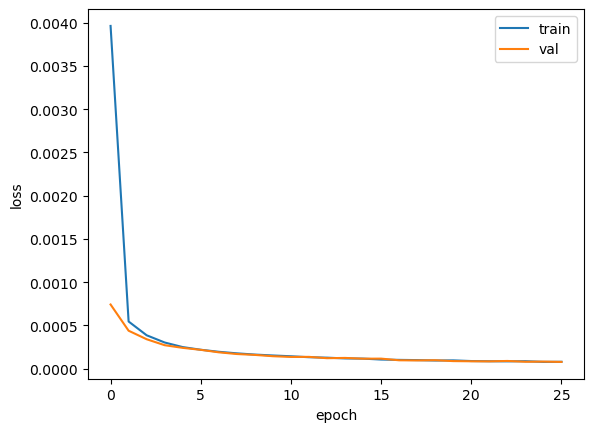

In [13]:
plt.plot(np.array(epoch_loss))
plt.plot(np.array(epoch_loss_val))
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 3.3 Performance on test set

In [14]:
loaded_model = Autoencoder(input_dim=X_filled.shape[1])

# Load the state dictionary
loaded_model.load_state_dict(torch.load(f"autoencoder_epoch_{best_epoch + 1}.pth"))

# Move the loaded model to the desired device (CPU or GPU)
loaded_model.to(device)

# Now you can use the loaded_model for inference or further training
# For example, set it to evaluation mode if you are doing inference
loaded_model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=343, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=343, bias=True)
  )
)

In [15]:
#mask_test = !~torch.isna(X_test).float()
X_test_filled = torch.nan_to_num(X_test, nan = 0.0).float()

output_test = loaded_model(X_test_filled.to(device))
error = criterion(output_test.cpu(), X_test_filled)
point_error = torch.mean(error, dim=1)

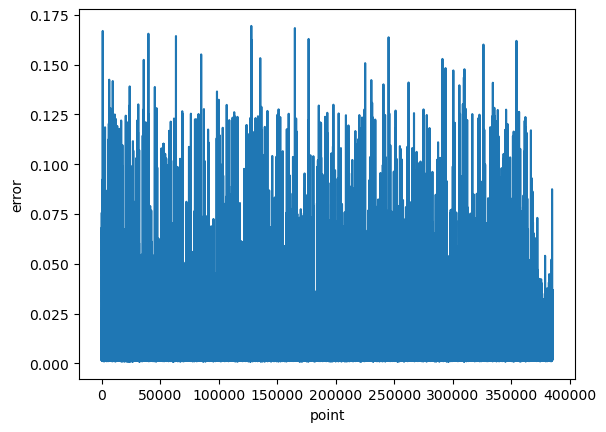

In [16]:
plt.plot(point_error.detach().numpy())
plt.xlabel('point')
plt.ylabel('error')
plt.show()

In [ ]:


'''
# Make sure they are on CPU and convert to numpy arrays if necessary for sklearn
y_true_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test
y_pred_np = pred_fraud.cpu().numpy() if isinstance(pred_fraud, torch.Tensor) else pred_fraud

# Calculate the confusion matrix
cm = confusion_matrix(y_true_np, y_pred_np)

print("Confusion Matrix:")
print(cm)

# The confusion matrix is typically structured as:
# [[True Negatives (TN), False Positives (FP)]
#  [False Negatives (FN), True Positives (TP)]]

# You can extract these values:
tn, fp, fn, tp = cm.ravel()

print(f"\nTrue Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")'''

In [ ]:
for threshold in np.arange(0.05, 0.2, 0.01):
    pred_fraud = torch.where(point_error > threshold, 1, 0) # if > threshold, mark as 1, else mark as 0
    print(f"threshold: {threshold:.2f}")
    print(confusion_matrix(y_test.cpu().numpy(), pred_fraud.cpu().numpy()))
    print(f"f1: {f1_score(y_test.cpu().numpy(), pred_fraud.cpu().numpy())}")


In [19]:
print(roc_auc_score(y_test, point_error.detach().numpy()))

0.6433656387300791


If need to clear up cached memory

In [ ]:
import gc
import torch

# Example: assuming you have a large tensor 'large_tensor' on the GPU
# del large_tensor

# Run Python's garbage collector
gc.collect()

# Empty the PyTorch CUDA cache
torch.cuda.empty_cache()

print("GPU memory freed.")

To load a saved model state, you can do the following:

In [32]:
data = {
    'Xtrain': X_filled,
    'Masktrain': mask_train, 
    'Xval': X_val_filled, 
    'Maskval': mask_val,
    'Xtest': X_test_filled
}

In [33]:
torch.save(data, 'train_test_data.pt')